In [1]:
# https://x.com/akshay_pachaar/status/1927372063259377984
# https://github.com/patchy631/ai-engineering-hub/tree/main/financial-analyst-deepseek

In [2]:
import re
import json
import os
import yfinance as yf
from crewai import Agent, Task, Crew, Process, LLM
from crewai_tools import CodeInterpreterTool, FileReadTool

In [3]:
from dotenv import load_dotenv  
load_dotenv('API_KEYS.env')  
llm = LLM(
    model="gpt-3.5-turbo",
    stream=True  # Enable streaming
)

#llm = LLM(
#    model="ollama/deepseek-r1:7b",
#    base_url="http://localhost:11434",
#    # temperature=0.7)


In [4]:
from pydantic import BaseModel, Field

class QueryAnalysisOutput(BaseModel):
    """Structured output for the query analysis task."""
    symbol: str = Field(..., description="Stock ticker symbol (e.g., TSLA, AAPL).")
    timeframe: str = Field(..., description="Time period (e.g., '1d', '1mo', '1y').")
    action: str = Field(..., description="Action to be performed (e.g., 'fetch', 'plot').")

In [5]:


# 1) Query parser agent
query_parser_agent = Agent(
    role="Stock Data Analyst",
    goal="Extract stock details and fetch required data from this user query: {query}.",
    backstory="You are a financial analyst specializing in stock market data retrieval.",
    llm=llm,
    verbose=True,
    memory=True,
)

query_parsing_task = Task(
    description="Analyze the user query and extract stock details.",
    expected_output="A dictionary with keys: 'symbol', 'timeframe', 'action'.",
    output_pydantic=QueryAnalysisOutput,
    agent=query_parser_agent,
)


# 2) Code writer agent
code_writer_agent = Agent(
    role="Senior Python Developer",
    goal="Write Python code to visualize stock data.",
    backstory="""You are a Senior Python developer specializing in stock market data visualization. 
                 You are also a Pandas, Matplotlib and yfinance library expert.
                 You are skilled at writing production-ready Python code""",
    llm=llm,
    verbose=True,
)

code_writer_task = Task(
    description="""Write Python code to visualize stock data based on the inputs from the stock analyst
                   where you would find stock symbol, timeframe and action.""",
    expected_output="A clean and executable Python script file (.py) for stock visualization.",
    agent=code_writer_agent,
)


# 3) Code interpreter agent (uses code interpreter tool from crewai)
code_interpreter_tool = CodeInterpreterTool()

code_execution_agent = Agent(
    role="Senior Code Execution Expert",
    goal="Review and execute the generated Python code by code writer agent to visualize stock data.",
    backstory="You are a code execution expert. You are skilled at executing Python code.",
    # tools=[code_interpreter_tool],
    allow_code_execution=True,   # This automatically adds the CodeInterpreterTool
    llm=llm,
    verbose=True,
)

code_execution_task = Task(
    description="""Review and execute the generated Python code by code writer agent to visualize stock data.""",
    expected_output= "A clean and executable Python script file (.py) for stock visualization. remove any lines that are not executable like title",
    agent=code_execution_agent,
)


In [6]:
#### --- CREW SETUP --- ###

crew = Crew(
    agents=[query_parser_agent, code_writer_agent, code_execution_agent],
    tasks=[query_parsing_task, code_writer_task, code_execution_task],
    process=Process.sequential
)

# Run the crew with an example query
result = crew.kickoff(inputs={"query": "Plot 2024 stock values of IBM and plot 2024 stock values of TESLA in the same figure"})

# Agent: Stock Data Analyst
## Task: Analyze the user query and extract stock details.
I now can give a great answer

Final Answer:
{
  "symbol": "IBM and TESLA",
  "timeframe": "2024",
  "action": "Plot stock values for IBM and TESLA in the same figure"
}

# Agent: Stock Data Analyst
## Final Answer: 
{
  "symbol": "IBM and TESLA",
  "timeframe": "2024",
  "action": "Plot stock values for IBM and TESLA in the same figure"
}


# Agent: Senior Python Developer
## Task: Write Python code to visualize stock data based on the inputs from the stock analyst
                   where you would find stock symbol, timeframe and action.
I now can give a great answer

Final Answer:
```python
# SeniorPythonDev_StockVisualization.py

import yfinance as yf
import matplotlib.pyplot as plt

# Stock symbol, timeframe, and action from the stock analyst
symbol = "IBM TSLA"
timeframe = "2024"
action = "Plot stock values for IBM and TESLA in the same figure"

# Split the symbols
symbols = symbol.split()

# 

import yfinance as yf
import matplotlib.pyplot as plt

symbol = 'IBM TSLA'
symbols = symbol.split()

stock_data = yf.download(symbols, period='1y')

plt.figure(figsize=(14, 7))
for sym in symbols:
    plt.plot(stock_data['Close'][sym], label=sym)

plt.title(f'Stock Prices for {', '.join(symbols)} in 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)
plt.legend()
plt.show()
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


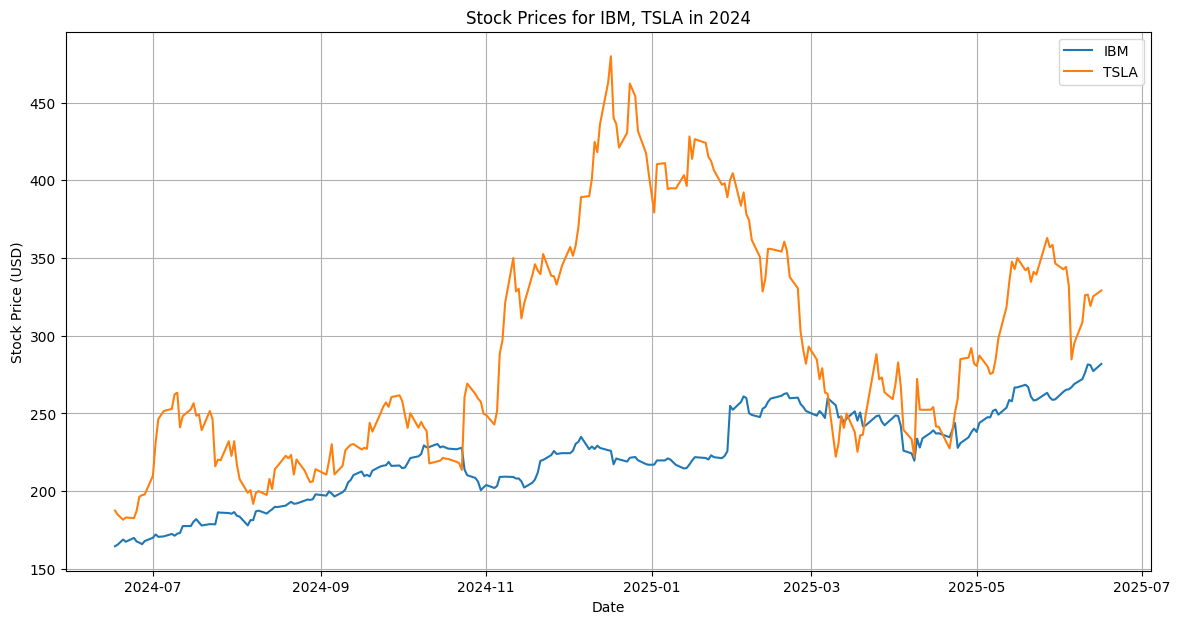

In [7]:
result.raw
# Clean it by removing the first and last lines
lines = result.raw.strip().splitlines()
clean_code = "\n".join(lines[1:-1])

# Now it's ready to write to a .py file or execute
print(clean_code)
exec(clean_code)

In [8]:
result.raw

"```python\nimport yfinance as yf\nimport matplotlib.pyplot as plt\n\nsymbol = 'IBM TSLA'\nsymbols = symbol.split()\n\nstock_data = yf.download(symbols, period='1y')\n\nplt.figure(figsize=(14, 7))\nfor sym in symbols:\n    plt.plot(stock_data['Close'][sym], label=sym)\n\nplt.title(f'Stock Prices for {', '.join(symbols)} in 2024')\nplt.xlabel('Date')\nplt.ylabel('Stock Price (USD)')\nplt.grid(True)\nplt.legend()\nplt.show()\n```"